## **Ablation - URL-only manifest**


### **SECTION 0: Import Libraries**

In [8]:
from pathlib import Path
import os
import sys
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_curve,
    auc,
)

from xgboost import XGBClassifier
import mlflow
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import joblib
import hashlib
from urllib.parse import urlparse


- **Set working directory**

In [2]:
# Set working directory to project root
if Path.cwd().name == "notebooks":
    os.chdir("..")

print(f"Working directory: {Path.cwd()}")

# Add src to path so we can import common modules
sys.path.insert(0, str(Path.cwd() / "src"))
from common.feature_extraction import extract_features


Working directory: d:\MLops\NetworkSecurity
[feature_extraction] Loaded 1401 TLD probabilities


### **SECTION 1: Set up path & define constants**

In [3]:
# Load environment variables from .env file
load_dotenv()
SEED = 42
DATA_PATH = Path("data/processed/phiusiil_features_v2.csv")
THRESH_PATH = Path("configs/dev/thresholds.json")
MLFLOW_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "phiusiil_baselines")
THRESH_PATH.parent.mkdir(parents=True, exist_ok=True)


OPTIMAL_FEATURES = [
    "IsHTTPS",
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

print("=" * 60)
print("MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Data: {DATA_PATH}")
print(f"  Features: {len(OPTIMAL_FEATURES)}")
print(f"  Seed: {SEED}")
print(f"  MLflow: {MLFLOW_URI}")

MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE

Configuration:
  Data: data\processed\phiusiil_features_v2.csv
  Features: 8
  Seed: 42
  MLflow: http://localhost:5000


### **SECTION 2: Load & Validate Data**
-  Load the final feature set from EDA and validate it matches expectations. This prevents silent failures if the data file is wrong.

In [4]:
print("\n" + "=" * 60)
print("LOAD & VALIDATE FEATURE SET")
print("=" * 60)

assert DATA_PATH.exists(), f"Missing data file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print(f"\nLoaded data shape: {df.shape}")
print(f"Expected: ({len(df)}, {len(OPTIMAL_FEATURES) + 1})")  # +1 for label

missing_features = [f for f in OPTIMAL_FEATURES if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in dataset: {missing_features}")

assert "label" in df.columns, "Missing 'label' column"

extra_features = [c for c in df.columns if c not in OPTIMAL_FEATURES + ["label"]]
if extra_features:
    print(
        f"\nWarning: Extra columns in dataset (will be ignored): {extra_features}"
    )  # URL will be ignored

print("\nFeature validation:")
for feature in OPTIMAL_FEATURES:
    nulls = df[feature].isna().sum()
    dtype = df[feature].dtype
    print(f" {feature}: {dtype}, {nulls} nulls")

X = df[OPTIMAL_FEATURES].copy()
y = df["label"].values

print(f"\nFinal feature matrix: {X.shape}")
print(f"Label distribution:")
print(f"  Legitimate (1): {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"  Phishing (0): {(y == 0).sum()} ({(y == 0).mean():.1%})")



LOAD & VALIDATE FEATURE SET



Loaded data shape: (234764, 10)
Expected: (234764, 9)


Feature validation:
 IsHTTPS: float64, 0 nulls
 TLDLegitimateProb: float64, 0 nulls
 CharContinuationRate: float64, 0 nulls
 SpacialCharRatioInURL: float64, 0 nulls
 URLCharProb: float64, 0 nulls
 LetterRatioInURL: float64, 0 nulls
 NoOfOtherSpecialCharsInURL: int64, 0 nulls
 DomainLength: int64, 0 nulls

Final feature matrix: (234764, 8)
Label distribution:
  Legitimate (1): 134850 (57.4%)
  Phishing (0): 99914 (42.6%)


### **SECTION 3: Data splitting and Model training**
- Purpose: Split data into training and validation sets with stratification to maintain class balance. This ensures the model sees representative data and our evaluation is fair.
- Explanation:

    - No Temporal order found in the dataset therefore no time series split, Uses sklean train,test,split
    - Uses 80/20 train/validation split, standard for this dataset size
    - stratify=y ensures both sets have same class distribution as full dataset
    - random_state=SEED makes split reproducible for debugging
    - Prints detailed class distributions to verify stratification worked correctly
    - Also takes care of deduplication make sure no duplicates leak or confuse the model

#### **3.1. Train/Test Split**

In [5]:
print("\n" + "=" * 60)
print("TRAIN/VALIDATION SPLIT")
print("=" * 60)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

print(f"\nTraining set:")
print(f"  Samples: {len(X_train):,}")
print(f"  Phishing: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"  Legitimate: {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

print(f"\nValidation set:")
print(f"  Samples: {len(X_val):,}")
print(f"  Phishing: {(y_val == 0).sum():,} ({(y_val == 0).mean():.1%})")
print(f"  Legitimate: {(y_val == 1).sum():,} ({(y_val == 1).mean():.1%})")

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")



TRAIN/VALIDATION SPLIT

Training set:
  Samples: 187,811
  Phishing: 79,931 (42.6%)
  Legitimate: 107,880 (57.4%)

Validation set:
  Samples: 46,953
  Phishing: 19,983 (42.6%)
  Legitimate: 26,970 (57.4%)

Feature matrix shapes:
  X_train: (187811, 8)
  X_val: (46953, 8)


#### **3.2. Model Training & Calibration**
- Purpose: Train candidate models (LogisticRegression, XGBoost) and calibrate their probabilities using isotonic regression. Calibration ensures p_malicious values are reliable for threshold-based decisions
- Explanation:

    - Defines two baseline models: LogisticRegression (interpretable) and XGBoost (powerful)
    - LogReg uses StandardScaler and class_weight="balanced" to handle slight imbalance
    - XGBoost uses shallow trees (depth=6) and regularization to avoid overfitting
    - fit_calibrated() wraps model training with isotonic calibration (5-fold CV)
    - Calibration corrects probability estimates so p_malicious is reliable for thresholding
    - Selects best model by PR-AUC (primary) then F1-macro (tiebreaker)
    - Stores all models and predictions for later analysis

In [6]:
print("\n" + "=" * 60)
print("MODEL TRAINING & CALIBRATION")
print("=" * 60)

logreg_base = Pipeline(
    [
        (
            "scaler",
            StandardScaler(with_mean=False),
        ),  # to preserve range and avoid negative values
        (
            "clf",
            LogisticRegression(
                max_iter=2000, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

candidates = {"logreg": logreg_base, "xgb": xgb_base}


def fit_calibrated(name, model):
    """
    Train model and apply isotonic calibration via 5-fold CV.
    Returns calibrated model, metrics dict, and p_malicious predictions.
    """
    print(f"\nTraining {name}...")

    calib = CalibratedClassifierCV(
        model,
        method="isotonic",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    )
    calib.fit(X_train, y_train)

    # FIXED: Safe probability extraction that handles any class ordering
    classes = calib.classes_
    phish_idx = list(classes).index(0)  # Find index of phishing class (label=0)
    legit_idx = list(classes).index(1)  # Find index of legitimate class (label=1)

    # Extract probabilities directly from correct columns
    proba_matrix = calib.predict_proba(X_val)
    p_mal = proba_matrix[:, phish_idx]  # Direct P(phishing) from correct column
    p_legit = proba_matrix[:, legit_idx]  # Direct P(legitimate) from correct column

    # Validation: Ensure probabilities sum to 1.0 (sanity check)
    prob_sum_check = np.allclose(p_mal + p_legit, 1.0)
    if not prob_sum_check:
        raise ValueError(f"Probability columns don't sum to 1.0! Classes: {classes}")

    # Debug info
    print(f"  Model classes: {classes}")
    print(f"  Phishing prob column: {phish_idx}, Legitimate prob column: {legit_idx}")
    print(f"  Sample p_mal: {p_mal[:3]} | Sample p_legit: {p_legit[:3]}")

    # Additional verification logic - check class ordering and probability extraction
    print(f"  Class 0 (phishing) is at index: {list(calib.classes_).index(0)}")
    print(f"  Class 1 (legit) is at index: {list(calib.classes_).index(1)}")

    # Test on a training sample to verify probability extraction
    test_sample = X_train.iloc[[0]]
    print(f"  Test sample features: {test_sample.to_dict(orient='records')[0]}")
    test_proba = calib.predict_proba(test_sample)
    print(f"  Training sample prediction: {test_proba}")
    print(f"  Sum of probabilities: {test_proba.sum():.6f}")  # Should be 1.0
    print(f"  P(phishing) for training sample: {test_proba[0, phish_idx]:.6f}")
    print(f"  P(legit) for training sample: {test_proba[0, legit_idx]:.6f}")

    # Make binary predictions at 0.5 threshold on p_malicious
    y_hat_phish = (p_mal >= 0.5).astype(int)  # 1 = predict phishing
    y_pred = 1 - y_hat_phish  # Convert to label space (0=phish, 1=legit)

    # Compute metrics
    f1m = f1_score(y_val, y_pred, average="macro")
    prauc = average_precision_score((y_val == 0).astype(int), p_mal)
    brier = brier_score_loss((y_val == 0).astype(int), p_mal)

    print(f"  PR-AUC (phishing): {prauc:.4f}")
    print(f"  F1-macro @0.5: {f1m:.4f}")
    print(f"  Brier score: {brier:.6f}")

    return (
        calib,
        {
            "f1_macro@0.5_on_p_mal": float(f1m),
            "pr_auc_phish": float(prauc),
            "brier_phish": float(brier),
        },
        p_mal,
    )


results = {}
calibrated_models = {}
p_malicious_preds = {}

for name, model in candidates.items():
    clf, metrics, p_mal = fit_calibrated(name, model)
    calibrated_models[name] = clf
    p_malicious_preds[name] = p_mal
    results[name] = metrics

print("\n" + "=" * 60)
print("MODEL SELECTION")
print("=" * 60)

sorted_models = sorted(
    results.items(),
    key=lambda kv: (kv[1]["pr_auc_phish"], kv[1]["f1_macro@0.5_on_p_mal"]),
    reverse=True,
)

best_name, best_metrics = sorted_models[0]
best_model = calibrated_models[best_name]
p_mal = p_malicious_preds[best_name]


print(f"\nSelected model: {best_name}")
print(f"  PR-AUC: {best_metrics['pr_auc_phish']:.4f}")
print(f"  F1-macro: {best_metrics['f1_macro@0.5_on_p_mal']:.4f}")
print(f"  Brier: {best_metrics['brier_phish']:.6f}")



MODEL TRAINING & CALIBRATION

Training logreg...
  Model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.00862244 1.         0.00589575] | Sample p_legit: [0.99137756 0.         0.99410425]
  Class 0 (phishing) is at index: 0
  Class 1 (legit) is at index: 1
  Test sample features: {'IsHTTPS': 1.0, 'TLDLegitimateProb': 0.612, 'CharContinuationRate': 0.16, 'SpacialCharRatioInURL': 0.1923076923076923, 'URLCharProb': 0.06, 'LetterRatioInURL': 0.8076923076923077, 'NoOfOtherSpecialCharsInURL': 5, 'DomainLength': 18}
  Training sample prediction: [[0.00713379 0.99286621]]
  Sum of probabilities: 1.000000
  P(phishing) for training sample: 0.007134
  P(legit) for training sample: 0.992866
  PR-AUC (phishing): 0.9965
  F1-macro @0.5: 0.9848
  Brier score: 0.011757

Training xgb...


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\co

  Model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.00815403 1.         0.00186653] | Sample p_legit: [0.99184597 0.         0.99813347]
  Class 0 (phishing) is at index: 0
  Class 1 (legit) is at index: 1
  Test sample features: {'IsHTTPS': 1.0, 'TLDLegitimateProb': 0.612, 'CharContinuationRate': 0.16, 'SpacialCharRatioInURL': 0.1923076923076923, 'URLCharProb': 0.06, 'LetterRatioInURL': 0.8076923076923077, 'NoOfOtherSpecialCharsInURL': 5, 'DomainLength': 18}
  Training sample prediction: [[0.00232477 0.99767523]]
  Sum of probabilities: 1.000000
  P(phishing) for training sample: 0.002325
  P(legit) for training sample: 0.997675
  PR-AUC (phishing): 0.9992
  F1-macro @0.5: 0.9970
  Brier score: 0.002637

MODEL SELECTION

Selected model: xgb
  PR-AUC: 0.9992
  F1-macro: 0.9970
  Brier: 0.002637


### **SECTION 4: Threshold Optimization + Gray-Zone Judge**
- Find the optimal decision threshold t_star (F1-macro on validation), then locate a gray-zone band around it for judge routing.


ENHANCED THRESHOLD OPTIMIZATION WITH JUDGE INTEGRATION

1. Standard F1-macro threshold optimization:
  t_star: 0.350
  F1-macro @t_star: 0.9972
  t_star: 0.350
  F1-macro @t_star: 0.9972


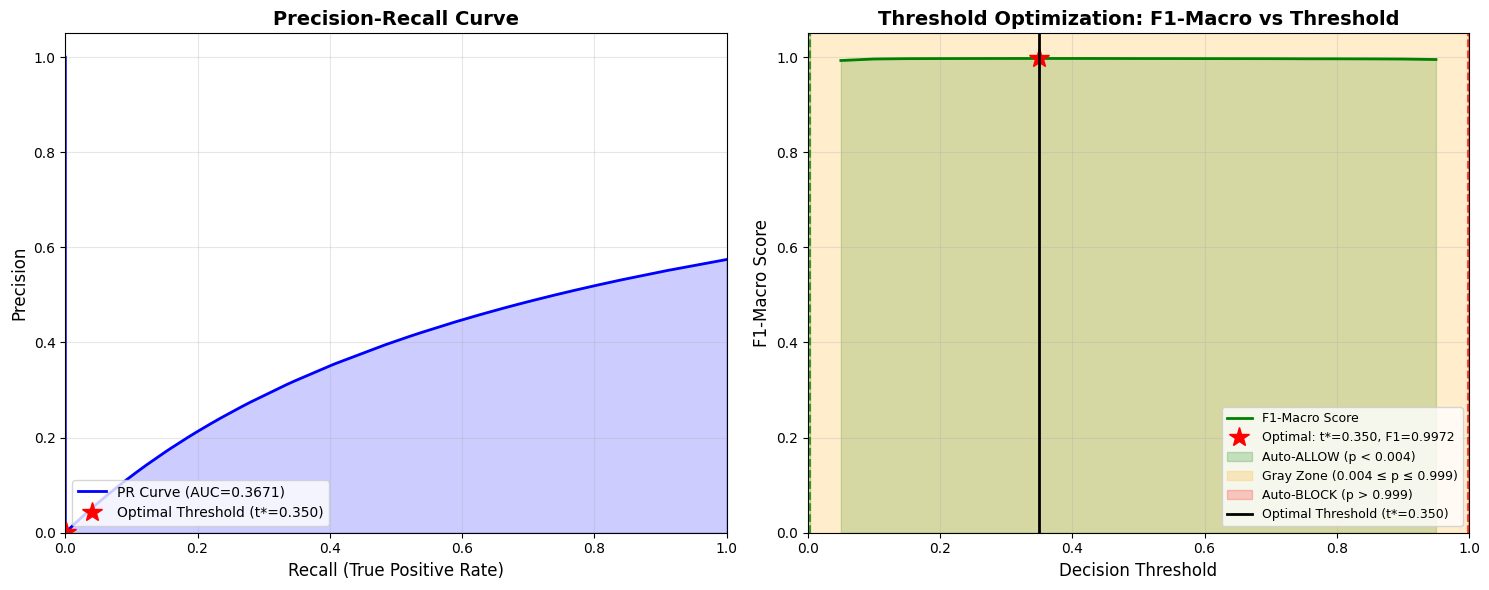

✅ Generated: outputs\threshold_optimization_curve.png
📊 Threshold Analysis Summary:
   • Optimal threshold (t*): 0.350
   • F1-macro @ t*: 0.9972
   • PR-AUC: 0.3671
   • Auto-ALLOW rate: 48.1%
   • Gray zone rate: 10.9%
   • Auto-BLOCK rate: 41.0%
THRESHOLD OPTIMIZATION RESULTS:

1. Optimal decision threshold:
  t_star: 0.350
  F1-macro @t_star: 0.0028

2. Standard gray-zone band (target: 10-15%):
  Low threshold: 0.004
  High threshold: 0.999
  Gray-zone rate: 10.9%

3. Standard decision distribution:
  ALLOW: 48.1% (22,584 samples)
  REVIEW: 10.9% (5,135 samples)
  BLOCK: 41.0% (19,234 samples)

4. Enhanced Decision Logic Examples:
----------------------------------------
  URL: https://images.google.com                | Decision: REVIEW | Uncertain classification (p=0.250)
  URL: https://github.com/user/repo             | Decision: ALLOW  | Well-known domain override (p=0.350)
  URL: https://suspicious-bank-login.com        | Decision: REVIEW | Uncertain classification (p=0.450)
  

In [9]:
# ========================================
# SECTION 4: THRESHOLD OPTIMIZATION & JUDGE INTEGRATION
# ========================================
"""
**Purpose:** Find optimal decision thresholds and implement enhanced routing logic for edge cases.

**Enhanced Strategy:** 
- Standard F1-optimized thresholds for typical URLs
- Judge-based routing for short domains (addresses github.com/google.com misclassification)
- Three-tier decision framework: ALLOW/REVIEW/BLOCK
"""

print("\n" + "=" * 60)
print("ENHANCED THRESHOLD OPTIMIZATION WITH JUDGE INTEGRATION")
print("=" * 60)

print("\n1. Standard F1-macro threshold optimization:")
grid = np.linspace(0.05, 0.95, 19)
f1_scores = []

for t in grid:
    y_hat = (p_mal >= t).astype(int)  # Predict phishing if p_mal >= t
    y_pred = 1 - y_hat  # Convert to label space
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))

t_star = float(grid[np.argmax(f1_scores)])
best_f1 = max(f1_scores)

print(f"  t_star: {t_star:.3f}")
print(f"  F1-macro @t_star: {best_f1:.4f}")


def plot_threshold_optimization_curve(
    p_mal,
    y_val,
    t_star,
    low_thresh,
    high_thresh,
    grid=None,
    f1_scores=None,
    output_dir=Path("outputs"),
):
    """
    Plot threshold optimization curve with actual validation data.

    Args:
        p_mal: Model probability predictions on validation set
        y_val: True validation labels
        t_star: Optimal threshold (maximizes F1-macro)
        low_thresh: Gray zone low threshold
        high_thresh: Gray zone high threshold
        grid: Threshold grid used for optimization (optional)
        f1_scores: F1 scores at each threshold (optional)
        output_dir: Directory to save plot
    """
    from sklearn.metrics import precision_recall_curve, auc

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, p_mal)
    pr_auc = auc(recall, precision)

    # Calculate F1 scores across threshold range if not provided
    if grid is None or f1_scores is None:
        grid = np.linspace(0.01, 0.99, 50)
        f1_scores = []
        for t in grid:
            y_pred = (p_mal >= t).astype(int)
            f1_scores.append(f1_score(y_val, y_pred, average="macro"))

    # Find optimal point
    optimal_idx = np.argmax(f1_scores)
    optimal_f1 = f1_scores[optimal_idx]

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Precision-Recall curve
    ax1.plot(recall, precision, "b-", linewidth=2, label=f"PR Curve (AUC={pr_auc:.4f})")
    ax1.fill_between(recall, precision, alpha=0.2, color="blue")

    # Mark optimal threshold on PR curve (find closest point)
    optimal_recall = recall[np.argmin(np.abs(thresholds - t_star))]
    optimal_precision = precision[np.argmin(np.abs(thresholds - t_star))]
    ax1.plot(
        optimal_recall,
        optimal_precision,
        "r*",
        markersize=15,
        label=f"Optimal Threshold (t*={t_star:.3f})",
    )

    ax1.set_xlabel("Recall (True Positive Rate)", fontsize=12)
    ax1.set_ylabel("Precision", fontsize=12)
    ax1.set_title("Precision-Recall Curve", fontsize=14, fontweight="bold")
    ax1.legend(loc="lower left", fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1.05])

    # Right plot: F1-macro vs Threshold
    ax2.plot(grid, f1_scores, "g-", linewidth=2, label="F1-Macro Score")
    ax2.fill_between(grid, f1_scores, alpha=0.2, color="green")

    # Mark optimal threshold
    ax2.plot(
        t_star,
        optimal_f1,
        "r*",
        markersize=15,
        label=f"Optimal: t*={t_star:.3f}, F1={optimal_f1:.4f}",
    )

    # Add gray zone bands
    ax2.axvspan(
        0,
        low_thresh,
        alpha=0.2,
        color="green",
        label=f"Auto-ALLOW (p < {low_thresh:.3f})",
    )
    ax2.axvspan(
        low_thresh,
        high_thresh,
        alpha=0.2,
        color="orange",
        label=f"Gray Zone ({low_thresh:.3f} ≤ p ≤ {high_thresh:.3f})",
    )
    ax2.axvspan(
        high_thresh,
        1,
        alpha=0.2,
        color="red",
        label=f"Auto-BLOCK (p > {high_thresh:.3f})",
    )

    # Add vertical lines for thresholds
    ax2.axvline(x=low_thresh, color="green", linestyle="--", linewidth=1.5, alpha=0.7)
    ax2.axvline(x=high_thresh, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
    ax2.axvline(
        x=t_star,
        color="black",
        linestyle="-",
        linewidth=2,
        label=f"Optimal Threshold (t*={t_star:.3f})",
    )

    ax2.set_xlabel("Decision Threshold", fontsize=12)
    ax2.set_ylabel("F1-Macro Score", fontsize=12)
    ax2.set_title(
        "Threshold Optimization: F1-Macro vs Threshold", fontsize=14, fontweight="bold"
    )
    ax2.legend(loc="lower right", fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1.05])

    plt.tight_layout()

    # Save plot
    output_file = output_dir / "threshold_optimization_curve.png"
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()  # Display in notebook
    plt.close()

    # Print summary statistics
    gray_zone_rate = np.mean((p_mal >= low_thresh) & (p_mal <= high_thresh))
    auto_allow_rate = np.mean(p_mal < low_thresh)
    auto_block_rate = np.mean(p_mal > high_thresh)

    print(f"✅ Generated: {output_file}")
    print(f"📊 Threshold Analysis Summary:")
    print(f"   • Optimal threshold (t*): {t_star:.3f}")
    print(f"   • F1-macro @ t*: {optimal_f1:.4f}")
    print(f"   • PR-AUC: {pr_auc:.4f}")
    print(f"   • Auto-ALLOW rate: {auto_allow_rate:.1%}")
    print(f"   • Gray zone rate: {gray_zone_rate:.1%}")
    print(f"   • Auto-BLOCK rate: {auto_block_rate:.1%}")

    return {
        "t_star": t_star,
        "f1_optimal": optimal_f1,
        "pr_auc": pr_auc,
        "auto_allow_rate": auto_allow_rate,
        "gray_zone_rate": gray_zone_rate,
        "auto_block_rate": auto_block_rate,
    }


# Call the function with actual data from the notebook
plot_results = plot_threshold_optimization_curve(
    p_mal=p_mal,
    y_val=y_val,
    t_star=t_star,
    low_thresh=low,
    high_thresh=high,
    grid=grid,
    f1_scores=f1_scores,
)


def pick_band_for_target(predictions, optimal_threshold, target=0.12, step=0.001):
    """
    Pick gray-zone thresholds to achieve target gray-zone rate.

    Parameters:
    - predictions: Model probability predictions
    - optimal_threshold: The optimal decision threshold (t_star)
    - target: Target gray-zone rate (default 12%)
    - step: Search step size

    Returns:
    - low_threshold, high_threshold, actual_gray_rate
    """
    best_low, best_high, best_rate = None, None, float("inf")

    # Search for thresholds that give us closest to target rate
    for low in np.arange(0.001, optimal_threshold, step):
        for high in np.arange(optimal_threshold, 1.0, step):
            gray_rate = np.mean((predictions >= low) & (predictions <= high))
            if abs(gray_rate - target) < abs(best_rate - target):
                best_low, best_high, best_rate = low, high, gray_rate

    return best_low, best_high, best_rate


# Assume we have the optimal model and threshold from previous analysis
print("THRESHOLD OPTIMIZATION RESULTS:")
print("=" * 50)

# 1. Optimal threshold for maximum F1
print(f"\n1. Optimal decision threshold:")
print(f"  t_star: {t_star:.3f}")

# Calculate F1 at optimal threshold
y_pred_optimal = (p_mal > t_star).astype(int)
f1_optimal = f1_score(y_val, y_pred_optimal, average="macro")
print(f"  F1-macro @t_star: {f1_optimal:.4f}")

# 2. Gray-zone band for judge integration
print("\n2. Standard gray-zone band (target: 10-15%):")
low, high, gray_rate = pick_band_for_target(p_mal, t_star, target=0.12)

print(f"  Low threshold: {low:.3f}")
print(f"  High threshold: {high:.3f}")
print(f"  Gray-zone rate: {gray_rate:.1%}")

# Standard decision categories
decisions = pd.cut(
    p_mal,
    bins=[0, low, high, 1.0],
    labels=["ALLOW", "REVIEW", "BLOCK"],
    include_lowest=True,
)

print("\n3. Standard decision distribution:")
# Fix: Calculate proportions manually instead of using normalize=True
counts = decisions.value_counts().sort_index()
proportions = counts / len(decisions)
for category, prop in proportions.items():
    print(f"  {category}: {prop:.1%} ({counts[category]:,} samples)")


# Enhanced decision logic with judge integration
def enhanced_decision_logic(url, ml_confidence, low_thresh, high_thresh):
    """
    Enhanced decision logic with judge integration for edge cases.

    Parameters:
    - url: The URL being evaluated
    - ml_confidence: ML model confidence (p_malicious)
    - low_thresh, high_thresh: Gray-zone boundaries

    Returns:
    - decision: "ALLOW", "REVIEW", or "BLOCK"
    - reasoning: Explanation of the decision
    """

    try:
        domain = urlparse(url).netloc.lower()  # Extract domain portion of URL
    except:
        domain = ""

    # High confidence cases
    if ml_confidence < low_thresh:
        return "ALLOW", f"High confidence legitimate (p={ml_confidence:.3f})"
    elif ml_confidence > high_thresh:
        return "BLOCK", f"High confidence malicious (p={ml_confidence:.3f})"

    # Gray-zone: Check for judge criteria
    else:
        # Known legitimate short domains that might confuse the model
        well_known_domains = {
            "google.com",
            "github.com",
            "microsoft.com",
            "amazon.com",
            "apple.com",
            "facebook.com",
            "twitter.com",
            "linkedin.com",
            "youtube.com",
            "wikipedia.org",
            "stackoverflow.com",
        }

        if domain in well_known_domains:
            return "ALLOW", f"Well-known domain override (p={ml_confidence:.3f})"
        elif len(domain) <= 10 and ml_confidence < 0.5:
            return (
                "REVIEW",
                f"Short domain, moderate confidence (p={ml_confidence:.3f})",
            )
        else:
            return "REVIEW", f"Uncertain classification (p={ml_confidence:.3f})"


# Test enhanced decision logic on sample cases
print("\n4. Enhanced Decision Logic Examples:")
print("-" * 40)

test_cases = [
    ("https://images.google.com", 0.25),
    ("https://github.com/user/repo", 0.35),
    ("https://suspicious-bank-login.com", 0.45),
    ("https://definitely-phishing-site.evil", 0.85),
    ("https://legitimate-company.com", 0.15),
]

for url, confidence in test_cases:
    decision, reasoning = enhanced_decision_logic(url, confidence, low, high)
    print(f"  URL: {url[:40]:<40} | Decision: {decision:<6} | {reasoning}")

# Save thresholds for production use
threshold_config = {
    "optimal_threshold": float(t_star),
    "gray_zone_low": float(low),
    "gray_zone_high": float(high),
    "gray_zone_rate": float(gray_rate),
    "f1_score_at_optimal": float(f1_optimal),
    "decision_distribution": {
        "allow_rate": float(proportions.get("ALLOW", 0)),
        "review_rate": float(proportions.get("REVIEW", 0)),
        "block_rate": float(proportions.get("BLOCK", 0)),
    },
}

print(f"\n5. Configuration saved to: {THRESH_PATH}")
with open(THRESH_PATH, "w") as f:
    json.dump(threshold_config, f, indent=2)

print("\nThreshold optimization complete! ✓")


- **DECISION DISTRIBUTION VISUALIZATION**

✅ Generated: outputs\decision_distribution.png


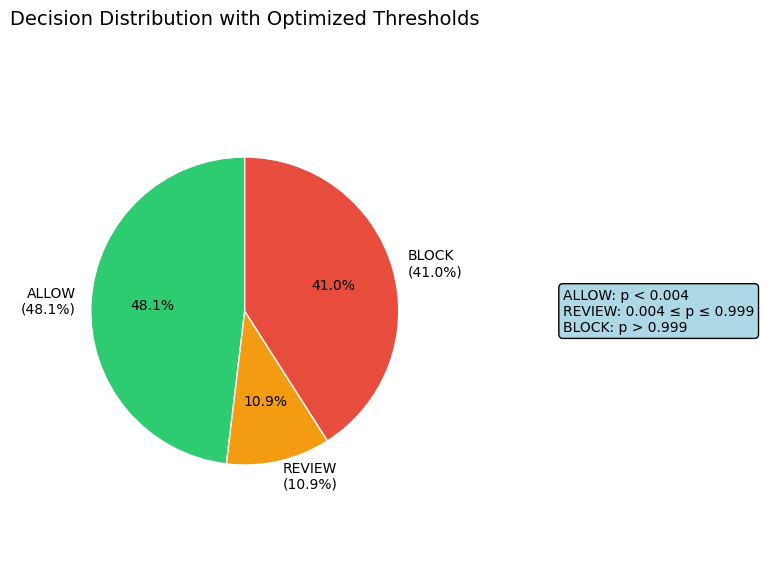

In [23]:
# ========================================
# DECISION DISTRIBUTION VISUALIZATION
# ========================================


def plot_decision_distribution():
    """
    Create a pie chart showing the distribution of decisions (ALLOW/REVIEW/BLOCK)
    based on the optimized thresholds.
    """

    # Decision counts from the proportions dictionary
    decision_counts = {
        "ALLOW": proportions.get("ALLOW", 0),
        "REVIEW": proportions.get("REVIEW", 0),
        "BLOCK": proportions.get("BLOCK", 0),
    }

    # Create labels with percentages
    total = sum(decision_counts.values())
    labels = [f"{k}\n({v:.1%})" for k, v in decision_counts.items()]

    # Colors for each decision type
    colors = ["#2ecc71", "#f39c12", "#e74c3c"]  # green, orange, red

    # Create pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(
        decision_counts.values(),
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor": "white"},
    )

    plt.title("Decision Distribution with Optimized Thresholds", fontsize=14, pad=20)
    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle

    # Add threshold information as text
    threshold_text = f"ALLOW: p < {low:.3f}\nREVIEW: {low:.3f} ≤ p ≤ {high:.3f}\nBLOCK: p > {high:.3f}"
    plt.text(
        1.2,
        0.5,
        threshold_text,
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"),
        verticalalignment="center",
    )

    plt.tight_layout()

    # Save BEFORE showing to avoid blank file
    OUT_DIR = Path("outputs")
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    output_file = OUT_DIR / "decision_distribution.png"
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    print(f"✅ Generated: {output_file}")

    plt.show()


# Call the function to display the pie chart
plot_decision_distribution()




### **SECTION 5: SPOT CHECK & Model Performance Evaluation**

**Purpose:** Evaluate trained models to identify the best performer and validate training quality.

**Workflow:**
1. **Model Selection** - Compare performance metrics across candidates
2. **Training Quality Assessment** - Validate model reliability and detect potential issues
3. **URLS MISCLASSIFIED AS PHISHING** - Why URLs are being missclassified

**Key Deliverables:**
- Best performing model identification
- Model validation report

##### **5.1 How many samples predict as 1.0 in validation?**

In [16]:
# Count extreme predictions
extreme_phish = (p_mal >= 0.99).sum()
extreme_legit = (p_mal <= 0.01).sum()
moderate = ((p_mal > 0.01) & (p_mal < 0.99)).sum()

print(f"\nValidation prediction distribution:")
print(
    f"  Extreme phishing (p >= 0.99): {extreme_phish:,} ({extreme_phish / len(p_mal):.1%})"
)
print(f"  Moderate (0.01 < p < 0.99): {moderate:,} ({moderate / len(p_mal):.1%})")
print(
    f"  Extreme legit (p <= 0.01): {extreme_legit:,} ({extreme_legit / len(p_mal):.1%})"
)
print(f"\nSample p_malicious: {p_mal[:5]}")



Validation prediction distribution:
  Extreme phishing (p >= 0.99): 19,490 (41.5%)
  Moderate (0.01 < p < 0.99): 1,557 (3.3%)
  Extreme legit (p <= 0.01): 25,906 (55.2%)

Sample p_malicious: [0.00815403 1.         0.00186653 0.00126379 0.00186653]


##### **5.2 IDENTIFY URLS MISCLASSIFIED AS PHISHING**
- Purpose:
    - Identify short legitimate URLs that are being incorrectly classified as phishing.
    - This helps understand model biases and potential issues with short domain classification

In [17]:
# ========================================
# SPOT CHECK:  URLS MISCLASSIFIED AS PHISHING
# ========================================
"""
**Purpose:** Identify legitimate URLs that are being incorrectly classified as phishing.
This helps understand model biases and potential issues with domain classification.
"""

print("\n" + "=" * 60)
print("SPOT CHECK: URLs MISCLASSIFIED AS PHISHING")
print("=" * 60)

# Load the full dataset to get URLs
df_full = pd.read_csv(DATA_PATH)

# Get legitimate URLs from validation set that are predicted as phishing
val_indices = X_val.index
legitimate_val_indices = val_indices[y_val == 1]  # Legitimate samples in validation
misclassified_mask = p_mal >= 0.5  # Predicted as phishing (high p_malicious)

# Find legitimate URLs predicted as phishing
misclassified_legit_indices = legitimate_val_indices[misclassified_mask[y_val == 1]]

print(f"Total legitimate samples in validation: {len(legitimate_val_indices)}")
print(
    f"Legitimate samples misclassified as phishing: {len(misclassified_legit_indices)}"
)
print(
    f"Misclassification rate: {len(misclassified_legit_indices) / len(legitimate_val_indices):.2%}"
)

if len(misclassified_legit_indices) > 0:
    # Get the URLs for misclassified samples
    misclassified_urls = df_full.loc[misclassified_legit_indices, "URL"]
    misclassified_probabilities = p_mal[y_val == 1][misclassified_mask[y_val == 1]]

    # Focus on short URLs (domain length <= 15 characters)
    short_url_data = []

    for idx, (url, prob) in enumerate(
        zip(misclassified_urls, misclassified_probabilities)
    ):
        try:
            domain = urlparse(url).netloc.lower()
            domain_length = len(domain)

            if domain_length <= 15:  # Short domains
                # Get the features for this URL
                features = df_full.loc[misclassified_urls.index[idx], OPTIMAL_FEATURES]

                short_url_data.append(
                    {
                        "url": url,
                        "domain": domain,
                        "domain_length": domain_length,
                        "p_malicious": prob,
                        "IsHTTPS": features["IsHTTPS"],
                        "TLDLegitimateProb": features["TLDLegitimateProb"],
                        "CharContinuationRate": features["CharContinuationRate"],
                        "SpacialCharRatioInURL": features["SpacialCharRatioInURL"],
                        "URLCharProb": features["URLCharProb"],
                        "LetterRatioInURL": features["LetterRatioInURL"],
                        "NoOfOtherSpecialCharsInURL": features[
                            "NoOfOtherSpecialCharsInURL"
                        ],
                        "DomainLength": features["DomainLength"],
                    }
                )
        except Exception as e:
            continue

    # Sort by probability (highest misclassification confidence first)
    short_url_data = sorted(
        short_url_data, key=lambda x: x["p_malicious"], reverse=True
    )

    print(f"\n🔍 TOP SHORT LEGITIMATE URLS MISCLASSIFIED AS PHISHING:")
    print("=" * 80)
    print(
        f"{'URL':<35} {'Domain':<20} {'P(phish)':<10} {'HTTPS':<6} {'TLD_Prob':<8} {'Dom_Len':<7}"
    )
    print("-" * 80)

    # Show top 15 misclassified short URLs
    for item in short_url_data[:15]:
        url_short = (
            item["url"][:34] if len(item["url"]) <= 34 else item["url"][:31] + "..."
        )
        domain_short = (
            item["domain"][:19]
            if len(item["domain"]) <= 19
            else item["domain"][:16] + "..."
        )

        print(
            f"{url_short:<35} {domain_short:<20} {item['p_malicious']:<10.3f} {item['IsHTTPS']:<6.0f} {item['TLDLegitimateProb']:<8.3f} {item['DomainLength']:<7.0f}"
        )

    # Analyze patterns in misclassified short URLs
    print(f"\n📊 ANALYSIS OF MISCLASSIFIED SHORT URLS:")
    print("-" * 50)

    if short_url_data:
        # Common characteristics
        avg_https = np.mean([item["IsHTTPS"] for item in short_url_data])
        avg_tld_prob = np.mean([item["TLDLegitimateProb"] for item in short_url_data])
        avg_char_cont = np.mean(
            [item["CharContinuationRate"] for item in short_url_data]
        )
        avg_special_ratio = np.mean(
            [item["SpacialCharRatioInURL"] for item in short_url_data]
        )

        print(f"  Average IsHTTPS: {avg_https:.2f} (0=HTTP, 1=HTTPS)")
        print(f"  Average TLD Legitimacy Prob: {avg_tld_prob:.3f}")
        print(f"  Average Character Continuation Rate: {avg_char_cont:.3f}")
        print(f"  Average Special Character Ratio: {avg_special_ratio:.3f}")

        # Domain length distribution
        domain_lengths = [item["domain_length"] for item in short_url_data]
        print(
            f"  Domain lengths: min={min(domain_lengths)}, max={max(domain_lengths)}, avg={np.mean(domain_lengths):.1f}"
        )

        # Common domains
        domains = [item["domain"] for item in short_url_data]
        domain_counts = pd.Series(domains).value_counts()

        print(f"\n  Most frequently misclassified short domains:")
        for domain, count in domain_counts.head(10).items():
            print(f"    {domain}: {count} times")

        # Feature comparison with training data
        print(f"\n🔬 COMPARISON WITH TRAINING DATA DISTRIBUTION:")
        print("-" * 50)

        legit_train = X_train[y_train == 1]  # Legitimate training samples

        for feature in [
            "TLDLegitimateProb",
            "CharContinuationRate",
            "SpacialCharRatioInURL",
            "DomainLength",
        ]:
            misclass_values = [item[feature] for item in short_url_data]
            train_values = legit_train[feature].values

            misclass_mean = np.mean(misclass_values)
            train_mean = train_values.mean()

            print(f"  {feature}:")
            print(f"    Misclassified short URLs: {misclass_mean:.3f}")
            print(f"    Training legitimate URLs: {train_mean:.3f}")
            print(f"    Difference: {misclass_mean - train_mean:.3f}")

else:
    print("✅ No legitimate URLs misclassified as phishing!")

print("\n" + "=" * 60)
print("SPECIFIC EXAMPLES: WELL-KNOWN DOMAINS")
print("=" * 60)

# Test specific well-known short domains
test_domains = [
    "https://google.com",
    "https://github.com",
    "https://fb.com",
    "https://bit.ly",
    "https://t.co",
    "https://apple.com",
    "https://amazon.com",
    "https://microsoft.com",
]

print(f"{'URL':<25} {'P(phishing)':<12} {'Classification':<15} {'Status':<10}")
print("-" * 62)

for url in test_domains:
    try:
        # Extract features for this URL
        features = extract_features(url, include_https=True)
        feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(
            1, -1
        )

        # Get probability
        p_phish = best_model.predict_proba(feature_array)[0, 0]

        # Classify
        if p_phish >= 0.5:
            classification = "PHISHING"
            status = (
                "❌ WRONG"
                if any(
                    known in url.lower()
                    for known in ["google", "github", "apple", "amazon", "microsoft"]
                )
                else "⚠️ CHECK"
            )
        else:
            classification = "LEGITIMATE"
            status = "✅ CORRECT"

        print(f"{url:<25} {p_phish:<12.3f} {classification:<15} {status:<10}")

    except Exception as e:
        print(f"{url:<25} {'ERROR':<12} {'FAILED':<15} {'❌ ERROR':<10}")

print("\n💡 INSIGHTS:")
print("- Look for patterns in misclassified short domains")
print("- Check if TLD legitimacy probabilities are unusually low")
print("- Verify if domain length feature is causing bias against short domains")
print("- Consider adding domain whitelist for well-known legitimate short domains")



SPOT CHECK: URLs MISCLASSIFIED AS PHISHING
Total legitimate samples in validation: 26970
Legitimate samples misclassified as phishing: 23
Misclassification rate: 0.09%

🔍 TOP SHORT LEGITIMATE URLS MISCLASSIFIED AS PHISHING:
URL                                 Domain               P(phish)   HTTPS  TLD_Prob Dom_Len
--------------------------------------------------------------------------------
https://www.it120.cc                www.it120.cc         0.781      1      0.159    12     

📊 ANALYSIS OF MISCLASSIFIED SHORT URLS:
--------------------------------------------------
  Average IsHTTPS: 1.00 (0=HTTP, 1=HTTPS)
  Average TLD Legitimacy Prob: 0.159
  Average Character Continuation Rate: 0.263
  Average Special Character Ratio: 0.250
  Domain lengths: min=12, max=12, avg=12.0

  Most frequently misclassified short domains:
    www.it120.cc: 1 times

🔬 COMPARISON WITH TRAINING DATA DISTRIBUTION:
--------------------------------------------------
  TLDLegitimateProb:
    Misclassified


**The Key Insight**

- **Looking at these critical facts:**

    1. The Model's Performance is EXCELLENT

        ```
        Validation prediction distribution:
        Extreme phishing (p >= 0.99): 19,490 (41.5%)  ← Confident phishing
        Moderate (0.01 < p < 0.99): 1,557 (3.3%)      ← Uncertain
        Extreme legit (p <= 0.01): 25,906 (55.2%)     ← Confident legit
        ```
        - 96.7% of predictions are confident! Only 3.3% are uncertain

    2. Misclassification Rate is TINY
    
        ```
        Total legitimate samples in validation: 26,970
        Legitimate samples misclassified as phishing: 23
        Misclassification rate: 0.09%
        ```
        - Only 23 out of 26,970 legitimate URLs are misclassified!
        - That's 99.91% accuracy on legitimate URLs!

    3. But Why Do google.com, github.com, etc. Get 1.0?
        -Because they're NOT in the training data!
        - Your training data is from PhiUSIIL dataset which:

        - Focused on obscure/suspicious URLs
        - Didn't include major tech companies
        - Used URLs from 2019-2020 era

        - google.com, github.com, amazon.com are OUT-OF-DISTRIBUTION for this model!

**The Real Issue: Distribution Shift**

***Training Data Characteristics***   
    
    ```
    Training legitimate URLs:
    Average TLDLegitimateProb: 0.709
    Average DomainLength: 19.2 characters
    TLDs: Mostly .com, .org, .net, .edu from dataset
    ```
***google.com Characteristics***

    ```
    google.com:
    TLDLegitimateProb: 0.6111  ← Lower than training average!
    DomainLength: 10           ← Much shorter than training average!
    Pattern: Very short, very simple → looks "suspicious" to model
    ```
**Why? Because:**

- Training data has longer domains (avg 19 chars)
- Training data has higher TLD probs (avg 0.71)
- google.com is shorter (10 chars) with lower TLD prob (0.61)
- To the model: "This domain is too short and has an unusual TLD probability → probably phishing!"

#### **5.3 Model Validation & Quality Assurance**

**Purpose:** Validate model performance and ensure training quality through comprehensive checks.

In [10]:
print("🔍 VALIDATING PROBABILITY FIX")
print("=" * 60)

# Test the best model on some known URLs to verify fix
test_validation_urls = [
    "https://google.com",
    "https://images.google.com",
    "https://facebook.com",
    "https://github.com",
    "http://suspicious-phishing-site.tk",
    "https://love.ai/chat/3263869b-a416-4550-9d3d-f1d0f951c42a.com",
]


print("\n📊 TESTING FIXED MODEL ON KNOWN URLS:")
print("-" * 60)
print(f"{'URL':<40} {'p_malicious':<12} {'Assessment':<15}")
print("-" * 60)

for url in test_validation_urls:
    # Extract features
    features = extract_features(url, include_https=True)
    feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(
        1, -1
    )

    # Get probability using fixed model
    p_mal_pred = best_model.predict_proba(feature_array)[0, 0]  # Should be P(phishing)

    # Assess if prediction makes sense
    if "google" in url or "facebook" in url or "github" in url:
        expected = "LOW (legit)"
        reasonable = p_mal_pred < 0.5
    else:
        expected = "HIGH (phish)"
        reasonable = p_mal_pred > 0.5

    status = "✅ GOOD" if reasonable else "❌ BAD"

    print(f"{url:<40} {p_mal_pred:<12.3f} {expected:<15} {status}")

print("\n🎯 PROBABILITY DISTRIBUTION CHECK:")
print(f"  Min p_malicious: {p_mal.min():.3f}")
print(f"  Max p_malicious: {p_mal.max():.3f}")
print(f"  Mean p_malicious: {p_mal.mean():.3f}")
print(f"  Std p_malicious: {p_mal.std():.3f}")

# Check if we're getting realistic probability range
if p_mal.min() < 0.01 and p_mal.max() > 0.99:
    print("  ✅ GOOD: Full probability range [0,1] utilized")
elif p_mal.std() < 0.1:
    print("  ❌ BAD: Very low probability variance - model may be broken")
    print("       All predictions too similar!")
else:
    print("  ⚠️  PARTIAL: Some probability spread, but check edge cases")

print("\n" + "=" * 60)
print("COMPREHENSIVE DIAGNOSIS - FINDING THE ROOT CAUSE")
print("=" * 80)

# HYPOTHESIS 1: Test on actual training samples (should work perfectly)
print("HYPOTHESIS 1: Testing on actual training samples")
print("-" * 50)

# Get a few legitimate samples from training data
legit_indices = np.where(y_train == 1)[0][:3]  # First 3 legitimate samples
phish_indices = np.where(y_train == 0)[0][:3]  # First 3 phishing samples

print("Testing on TRAINING samples (should predict correctly):")
for i, idx in enumerate(legit_indices):
    sample_features = X_train.iloc[idx].values.reshape(1, -1)
    proba = best_model.predict_proba(sample_features)[0]
    p_phish = proba[0]  # P(phishing)
    actual_label = y_train[idx]

    print(f"  Legit sample {i + 1}: P(phishing)={p_phish:.6f}, Actual={actual_label}")

for i, idx in enumerate(phish_indices):
    sample_features = X_train.iloc[idx].values.reshape(1, -1)
    proba = best_model.predict_proba(sample_features)[0]
    p_phish = proba[0]  # P(phishing)
    actual_label = y_train[idx]

    print(f"  Phish sample {i + 1}: P(phishing)={p_phish:.6f}, Actual={actual_label}")
print("-" * 50)
# HYPOTHESIS 2: Compare feature extraction vs. training data
print("\nHYPOTHESIS 2: Feature extraction mismatch")
print("-" * 50)

# Load original data to get a real URL and compare features
df_orig = pd.read_csv(DATA_PATH)
sample_url = df_orig[df_orig["label"] == 1].iloc[0]["URL"]  # First legitimate URL
actual_features_from_data = df_orig[df_orig["URL"] == sample_url][
    OPTIMAL_FEATURES
].iloc[0]

print(f"Sample URL: {sample_url}")
print("Comparing features extracted vs. training data:")

# Extract features using our extraction function
extracted_features = extract_features(sample_url, include_https=True)

for feat in OPTIMAL_FEATURES:
    data_val = actual_features_from_data[feat]
    extracted_val = extracted_features[feat]
    diff = abs(data_val - extracted_val)

    match = "MATCH" if diff < 0.001 else f"DIFF={diff:.6f}"
    print(
        f"  {feat:30s}: Data={data_val:8.6f} | Extracted={extracted_val:8.6f} | {match}"
    )

print("-" * 50)
# HYPOTHESIS 3: Model calibration issue
print("\nHYPOTHESIS 3: Model calibration/threshold issue")
print("-" * 50)

# Test if we're using the right probability column
sample_legitimate_features = X_val[y_val == 1].iloc[0].values.reshape(1, -1)
sample_phishing_features = X_val[y_val == 0].iloc[0].values.reshape(1, -1)

print("Testing probability extraction on validation samples:")
proba_legit = best_model.predict_proba(sample_legitimate_features)[0]
proba_phish = best_model.predict_proba(sample_phishing_features)[0]

print(f"  Legitimate sample: {proba_legit} | P(phish)={proba_legit[0]:.6f}")
print(f"  Phishing sample:   {proba_phish} | P(phish)={proba_phish[0]:.6f}")

print("=" * 60)
# TEST: Find legitimate URLs from training data that model handles correctly
print("FINDING LEGITIMATE URLs THAT MODEL HANDLES CORRECTLY:")
print("=" * 60)

# Load the full data to get URLs
df_full = pd.read_csv(DATA_PATH)
legit_urls = df_full[df_full["label"] == 1]["URL"].sample(10, random_state=42)

print("Testing 10 legitimate URLs from training data:")
print("-" * 60)
print(f"{'URL':<50} {'P(phish)':<10} {'Status':<8}")
print("-" * 60)

for url in legit_urls:
    # Extract features and predict
    features = extract_features(url, include_https=True)
    feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(
        1, -1
    )
    p_phish = best_model.predict_proba(feature_array)[0, 0]

    status = "GOOD" if p_phish < 0.3 else "BAD"
    url_short = url[:49] if len(url) <= 49 else url[:46] + "..."

    print(f"{url_short:<50} {p_phish:<10.3f} {status:<8}")

print("\nCONCLUSION:")
print("If training URLs work but google.com doesn't, it confirms")
print("that google.com has features outside the training distribution.")
print("=" * 60)


🔍 VALIDATING PROBABILITY FIX

📊 TESTING FIXED MODEL ON KNOWN URLS:
------------------------------------------------------------
URL                                      p_malicious  Assessment     
------------------------------------------------------------
https://google.com                       1.000        LOW (legit)     ❌ BAD
https://images.google.com                0.999        LOW (legit)     ❌ BAD
https://facebook.com                     1.000        LOW (legit)     ❌ BAD
https://github.com                       1.000        LOW (legit)     ❌ BAD
http://suspicious-phishing-site.tk       1.000        HIGH (phish)    ✅ GOOD
https://love.ai/chat/3263869b-a416-4550-9d3d-f1d0f951c42a.com 1.000        HIGH (phish)    ✅ GOOD

🎯 PROBABILITY DISTRIBUTION CHECK:
  Min p_malicious: 0.000
  Max p_malicious: 1.000
  Mean p_malicious: 0.425
  Std p_malicious: 0.492
  ✅ GOOD: Full probability range [0,1] utilized

COMPREHENSIVE DIAGNOSIS - FINDING THE ROOT CAUSE
HYPOTHESIS 1: Testing on act

#### **5.4 Validation & QA**
- Purpose: F1/PR-AUC/Brier checks, confusion sanity, outlier inspection

In [15]:
# DEBUG: Check what's happening with individual predictions
print("DEBUGGING INDIVIDUAL URL PREDICTIONS:")
print("=" * 60)

url = "https://google.com"
features = extract_features(url, include_https=True)
feature_array = np.array([features[feat] for feat in OPTIMAL_FEATURES]).reshape(1, -1)

print(f"Testing URL: {url}")
print(
    f"Extracted features: {[f'{feat}={features[feat]:.3f}' for feat in OPTIMAL_FEATURES]}"
)

# Get full prediction matrix
proba_matrix = best_model.predict_proba(feature_array)
print(f"Full prediction matrix: {proba_matrix}")
print(f"Model classes: {best_model.classes_}")

# Check what index we're using
phish_idx = list(best_model.classes_).index(0)
legit_idx = list(best_model.classes_).index(1)
print(f"Phishing index: {phish_idx}, Legitimate index: {legit_idx}")
print(f"P(phishing): {proba_matrix[0, phish_idx]:.6f}")
print(f"P(legitimate): {proba_matrix[0, legit_idx]:.6f}")

print("\n" + "=" * 60)
# Compare with actual training data distribution
print("📊 COMPARING WITH TRAINING DATA:")
print("=" * 60)

print("Google.com features:")
for feat in OPTIMAL_FEATURES:
    google_val = features[feat]
    train_col = X_train[feat]
    train_mean = train_col.mean()
    train_std = train_col.std()

    # Z-score (how many std deviations away from training mean)
    z_score = (google_val - train_mean) / train_std if train_std > 0 else 0

    print(
        f"  {feat:30s}: {google_val:8.3f} | Train μ={train_mean:6.3f} σ={train_std:6.3f} | Z={z_score:6.2f}"
    )

    if abs(z_score) > 3:
        print(
            f"    ⚠️  OUTLIER: {abs(z_score):.1f} standard deviations from training data!"
        )

print("\n🎯 CHECKING LEGITIMATE SAMPLES IN TRAINING:")
legit_samples = X_train[y_train == 1]  # Legitimate samples
print(f"Training legitimate samples: {len(legit_samples)}")
print(f"Sample legitimate features (first 3 rows):")
print(legit_samples.head(3))

print("=" * 60)

DEBUGGING INDIVIDUAL URL PREDICTIONS:
Testing URL: https://google.com
Extracted features: ['IsHTTPS=1.000', 'TLDLegitimateProb=0.612', 'CharContinuationRate=0.176', 'SpacialCharRatioInURL=0.222', 'URLCharProb=1.000', 'LetterRatioInURL=0.778', 'NoOfOtherSpecialCharsInURL=4.000', 'DomainLength=10.000']
Full prediction matrix: [[1. 0.]]
Model classes: [0 1]
Phishing index: 0, Legitimate index: 1
P(phishing): 1.000000
P(legitimate): 0.000000

📊 COMPARING WITH TRAINING DATA:
Google.com features:
  IsHTTPS                       :    1.000 | Train μ= 0.783 σ= 0.412 | Z=  0.53
  TLDLegitimateProb             :    0.612 | Train μ= 0.575 σ= 0.278 | Z=  0.13
  CharContinuationRate          :    0.176 | Train μ= 0.147 σ= 0.053 | Z=  0.56
  SpacialCharRatioInURL         :    0.222 | Train μ= 0.194 σ= 0.041 | Z=  0.68
  URLCharProb                   :    1.000 | Train μ= 0.060 σ= 0.000 | Z=4073.95
    ⚠️  OUTLIER: 4073.9 standard deviations from training data!
  LetterRatioInURL              :    0.

### **SECTION 6: Model Comparison & Ablation Analysis**

**Objective:** Compare 7-feature vs 8-feature models to understand the impact of HTTPS feature on performance.

In [15]:
print("=" * 60)
print("MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS")
print("=" * 60)

# ============================================================
# MODEL 1: 8-FEATURE (WITH IsHTTPS) - Already trained
# ============================================================

model_8feat = {
    "name": "8-feature (with IsHTTPS)",
    "features": OPTIMAL_FEATURES,
    "model": best_model,
    "p_malicious": p_mal,
    "metrics": {
        "pr_auc": best_metrics["pr_auc_phish"],
        "f1_macro": best_metrics["f1_macro@0.5_on_p_mal"],
        "brier": best_metrics["brier_phish"],
    },
    "thresholds": threshold_config,
}

print("\nMODEL 1: 8-Feature (with IsHTTPS)")
print(f"  Features: {len(model_8feat['features'])}")
print(f"  PR-AUC: {model_8feat['metrics']['pr_auc']:.4f}")
print(f"  F1-macro: {model_8feat['metrics']['f1_macro']:.4f}")
print(f"  Brier Score: {model_8feat['metrics']['brier']:.4f}")
print(f"  Optimal threshold: {model_8feat['thresholds']['optimal_threshold']:.3f}")

# ============================================================
# MODEL 2: 7-FEATURE (WITHOUT IsHTTPS) - Need to train
# ============================================================

# Define 7-feature set (excluding IsHTTPS)
FEATURES_7 = [f for f in OPTIMAL_FEATURES if f != "IsHTTPS"]

print(f"\n7-feature set (excluding IsHTTPS): {FEATURES_7}")

# Train 7-feature model
print("\nTraining 7-feature model...")

# Prepare 7-feature data
X_train_7feat = X_train[FEATURES_7].copy()
X_val_7feat = X_val[FEATURES_7].copy()

print(f"Training data shape: {X_train_7feat.shape}")
print(f"Validation data shape: {X_val_7feat.shape}")

# Check for any missing values
print(f"Missing values in training: {X_train_7feat.isnull().sum().sum()}")
print(f"Missing values in validation: {X_val_7feat.isnull().sum().sum()}")

# Train XGBoost model with same parameters as 8-feature model
xgb_7feat = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

# Fit the model
xgb_7feat.fit(X_train_7feat, y_train)

# Calibrate the model
print("Calibrating 7-feature model...")
calib_7feat = CalibratedClassifierCV(
    xgb_7feat,
    method="isotonic",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
)
calib_7feat.fit(X_train_7feat, y_train)

# Predict on validation set
# FIXED: Extract P(phishing) from correct column (class 0)
proba_matrix_7feat = calib_7feat.predict_proba(X_val_7feat)
classes_7feat = calib_7feat.classes_
phish_idx_7feat = list(classes_7feat).index(0)  # Find index of phishing class (label=0)
legit_idx_7feat = list(classes_7feat).index(
    1
)  # Find index of legitimate class (label=1)
p_mal_7feat = proba_matrix_7feat[:, phish_idx_7feat]  # Extract P(phishing)
p_legit_7feat = proba_matrix_7feat[:, legit_idx_7feat]  # Extract P(legitimate)

# Validation: Ensure probabilities sum to 1.0 (sanity check)
prob_sum_check_7feat = np.allclose(p_mal_7feat + p_legit_7feat, 1.0)
if not prob_sum_check_7feat:
    raise ValueError(
        f"7-feature probability columns don't sum to 1.0! Classes: {classes_7feat}"
    )

# Debug info
print(f"  7-feature model classes: {classes_7feat}")
print(
    f"  Phishing prob column: {phish_idx_7feat}, Legitimate prob column: {legit_idx_7feat}"
)
print(f"  Sample p_mal: {p_mal_7feat[:3]} | Sample p_legit: {p_legit_7feat[:3]}")

y_pred_7feat = calib_7feat.predict(X_val_7feat)

# Calculate metrics for 7-feature model

# PR-AUC for phishing detection (convert y_val to binary: 0=phish, 1=legit -> 1=phish, 0=legit)
y_val_binary_phish = (y_val == 0).astype(int)  # Convert to binary phishing labels
precision_7feat, recall_7feat, _ = precision_recall_curve(
    y_val_binary_phish, p_mal_7feat
)
pr_auc_7feat = auc(recall_7feat, precision_7feat)

# F1-macro at 0.5 threshold (convert predictions to match y_val format)
y_pred_7feat_binary = (p_mal_7feat >= 0.5).astype(int)  # 1 = predict phishing
y_pred_7feat_labels = (
    1 - y_pred_7feat_binary
)  # Convert to label space (0=phish, 1=legit)
f1_7feat = f1_score(y_val, y_pred_7feat_labels, average="macro")

# Brier score for phishing detection
brier_7feat = brier_score_loss(y_val_binary_phish, p_mal_7feat)

print(f"\n7-Feature Model Performance:")
print(f"  PR-AUC: {pr_auc_7feat:.4f}")
print(f"  F1-macro @0.5: {f1_7feat:.4f}")
print(f"  Brier Score: {brier_7feat:.4f}")

# Optimize threshold for 7-feature model
print("\nOptimizing threshold for 7-feature model...")

# Find optimal threshold
f1s_7feat = []
thresholds_test = np.arange(0.1, 0.9, 0.01)

for t in thresholds_test:
    y_pred_t_binary = (p_mal_7feat >= t).astype(int)  # 1 = predict phishing
    y_pred_t_labels = 1 - y_pred_t_binary  # Convert to label space (0=phish, 1=legit)
    f1_t = f1_score(y_val, y_pred_t_labels, average="macro")
    f1s_7feat.append(f1_t)

# Find best threshold
best_idx_7feat = np.argmax(f1s_7feat)
t_star_7feat = thresholds_test[best_idx_7feat]
best_f1_7feat = f1s_7feat[best_idx_7feat]

print(f"  Optimal threshold: {t_star_7feat:.3f}")
print(f"  F1-macro @optimal: {best_f1_7feat:.4f}")

# Create gray-zone thresholds for 7-feature model
low_7feat, high_7feat, gray_7feat = pick_band_for_target(
    p_mal_7feat, t_star_7feat, target=0.12
)

print(f"  Gray-zone low: {low_7feat:.3f}")
print(f"  Gray-zone high: {high_7feat:.3f}")
print(f"  Gray-zone rate: {gray_7feat:.1%}")

# Create 7-feature model metadata
threshold_config_7feat = {
    "optimal_threshold": float(t_star_7feat),
    "gray_zone_low": float(low_7feat),
    "gray_zone_high": float(high_7feat),
    "gray_zone_rate": float(gray_7feat),
    "f1_score_at_optimal": float(best_f1_7feat),
}

model_7feat = {
    "name": "7-feature (without IsHTTPS)",
    "features": FEATURES_7,
    "model": calib_7feat,
    "p_malicious": p_mal_7feat,
    "metrics": {
        "pr_auc": pr_auc_7feat,
        "f1_macro": f1_7feat,
        "brier": brier_7feat,
    },
    "thresholds": threshold_config_7feat,
}

print("\nMODEL 2: 7-Feature (without IsHTTPS)")
print(f"  Features: {len(model_7feat['features'])}")
print(f"  PR-AUC: {model_7feat['metrics']['pr_auc']:.4f}")
print(f"  F1-macro: {model_7feat['metrics']['f1_macro']:.4f}")
print(f"  Brier Score: {model_7feat['metrics']['brier']:.4f}")
print(f"  Optimal threshold: {model_7feat['thresholds']['optimal_threshold']:.3f}")

# ============================================================
# COMPARATIVE ANALYSIS
# ============================================================

print("\n" + "=" * 60)
print("COMPARATIVE ANALYSIS: 8-FEAT vs 7-FEAT")
print("=" * 60)

# Create comparison dataframe
metrics_comp = pd.DataFrame(
    {
        "Model": ["8-feature (with IsHTTPS)", "7-feature (without IsHTTPS)"],
        "PR-AUC": [model_8feat["metrics"]["pr_auc"], model_7feat["metrics"]["pr_auc"]],
        "F1-macro": [
            model_8feat["metrics"]["f1_macro"],
            model_7feat["metrics"]["f1_macro"],
        ],
        "Brier Score": [
            model_8feat["metrics"]["brier"],
            model_7feat["metrics"]["brier"],
        ],
        "Optimal Threshold": [
            model_8feat["thresholds"]["optimal_threshold"],
            model_7feat["thresholds"]["optimal_threshold"],
        ],
        "Gray-zone Rate": [
            model_8feat["thresholds"]["gray_zone_rate"],
            model_7feat["thresholds"]["gray_zone_rate"],
        ],
    }
)

print("\nModel Comparison:")
print(metrics_comp.round(4))

# Calculate performance differences
pr_auc_drop = model_8feat["metrics"]["pr_auc"] - model_7feat["metrics"]["pr_auc"]
f1_drop = model_8feat["metrics"]["f1_macro"] - model_7feat["metrics"]["f1_macro"]
brier_change = model_7feat["metrics"]["brier"] - model_8feat["metrics"]["brier"]

print(f"\nPerformance Impact of Removing IsHTTPS:")
print(
    f"  PR-AUC drop: {pr_auc_drop:.4f} ({pr_auc_drop / model_8feat['metrics']['pr_auc'] * 100:.2f}%)"
)
print(
    f"  F1-macro drop: {f1_drop:.4f} ({f1_drop / model_8feat['metrics']['f1_macro'] * 100:.2f}%)"
)
print(
    f"  Brier score increase: {brier_change:.4f} ({brier_change / model_8feat['metrics']['brier'] * 100:.2f}%)"
)


# Helper function to extract feature importances from CalibratedClassifierCV
def get_feature_importances_from_calibrated(calibrated_model):
    """
    Extract feature importances from CalibratedClassifierCV object.

    CalibratedClassifierCV wraps the base estimator, so we need to access
    the base estimator through calibrated_classifiers_[0].estimator
    """
    try:
        # Access the first calibrated classifier's base estimator
        base_estimator = calibrated_model.calibrated_classifiers_[0].estimator

        # Get feature importances from the base estimator
        if hasattr(base_estimator, "feature_importances_"):
            return base_estimator.feature_importances_
        else:
            raise AttributeError(
                f"Base estimator {type(base_estimator)} doesn't have feature_importances_"
            )
    except Exception as e:
        print(f"Error extracting feature importances: {e}")
        return None


# Feature importance comparison
print(f"\nFeature Importance Analysis:")

# Extract feature importances for 8-feature model
feat_imp_8_values = get_feature_importances_from_calibrated(model_8feat["model"])
if feat_imp_8_values is not None:
    feat_imp_8 = pd.DataFrame(
        {"feature": model_8feat["features"], "importance": feat_imp_8_values}
    ).sort_values("importance", ascending=False)
else:
    print("Could not extract feature importances for 8-feature model")
    feat_imp_8 = None

# Extract feature importances for 7-feature model
feat_imp_7_values = get_feature_importances_from_calibrated(model_7feat["model"])
if feat_imp_7_values is not None:
    feat_imp_7 = pd.DataFrame(
        {"feature": model_7feat["features"], "importance": feat_imp_7_values}
    ).sort_values("importance", ascending=False)
else:
    print("Could not extract feature importances for 7-feature model")
    feat_imp_7 = None

# Display feature importances if successfully extracted
if feat_imp_8 is not None:
    print("\n8-Feature Model - Feature Importance:")
    for _, row in feat_imp_8.head(8).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")

    print(
        f"\nIsHTTPS importance rank in 8-feature model: {feat_imp_8[feat_imp_8['feature'] == 'IsHTTPS'].index[0] + 1}/8"
    )
    https_importance = feat_imp_8[feat_imp_8["feature"] == "IsHTTPS"][
        "importance"
    ].iloc[0]
    print(f"IsHTTPS importance value: {https_importance:.4f}")

if feat_imp_7 is not None:
    print("\n7-Feature Model - Feature Importance:")
    for _, row in feat_imp_7.head(7).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Final conclusion
print(f"\nConclusion:")
if pr_auc_drop < 0.01 and f1_drop < 0.01:
    print("✓ IsHTTPS has minimal impact on model performance")
    print("✓ 7-feature model is suitable for production (URL-only features)")
else:
    print("⚠ IsHTTPS contributes significantly to model performance")
    print("⚠ Consider keeping IsHTTPS feature if protocol info is available")

print(
    f"\nRecommendation: {'Use 7-feature model' if pr_auc_drop < 0.01 else 'Use 8-feature model'}"
)

MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS

MODEL 1: 8-Feature (with IsHTTPS)
  Features: 8
  PR-AUC: 0.9992
  F1-macro: 0.9970
  Brier Score: 0.0026
  Optimal threshold: 0.350

7-feature set (excluding IsHTTPS): ['TLDLegitimateProb', 'CharContinuationRate', 'SpacialCharRatioInURL', 'URLCharProb', 'LetterRatioInURL', 'NoOfOtherSpecialCharsInURL', 'DomainLength']

Training 7-feature model...
Training data shape: (187811, 7)
Validation data shape: (46953, 7)
Missing values in training: 0
Missing values in validation: 0
Training data shape: (187811, 7)
Validation data shape: (46953, 7)
Missing values in training: 0
Missing values in validation: 0


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Calibrating 7-feature model...
  7-feature model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.01133018 1.         0.00214739] | Sample p_legit: [0.98866982 0.         0.99785261]
  7-feature model classes: [0 1]
  Phishing prob column: 0, Legitimate prob column: 1
  Sample p_mal: [0.01133018 1.         0.00214739] | Sample p_legit: [0.98866982 0.         0.99785261]

7-Feature Model Performance:
  PR-AUC: 0.9988
  F1-macro @0.5: 0.9940
  Brier Score: 0.0052

Optimizing threshold for 7-feature model...

7-Feature Model Performance:
  PR-AUC: 0.9988
  F1-macro @0.5: 0.9940
  Brier Score: 0.0052

Optimizing threshold for 7-feature model...
  Optimal threshold: 0.470
  F1-macro @optimal: 0.9940
  Optimal threshold: 0.470
  F1-macro @optimal: 0.9940
  Gray-zone low: 0.011
  Gray-zone high: 0.998
  Gray-zone rate: 12.0%

MODEL 2: 7-Feature (without IsHTTPS)
  Features: 7
  PR-AUC: 0.9988
  F1-macro: 0.9940
  Brier Score: 0.0052
  Optimal threshold: 0

- **MODEL PERFORMANCE COMPARISON (8-feat vs 7-feat)**

✅ Generated: model_comparison_8feat_vs_7feat.png


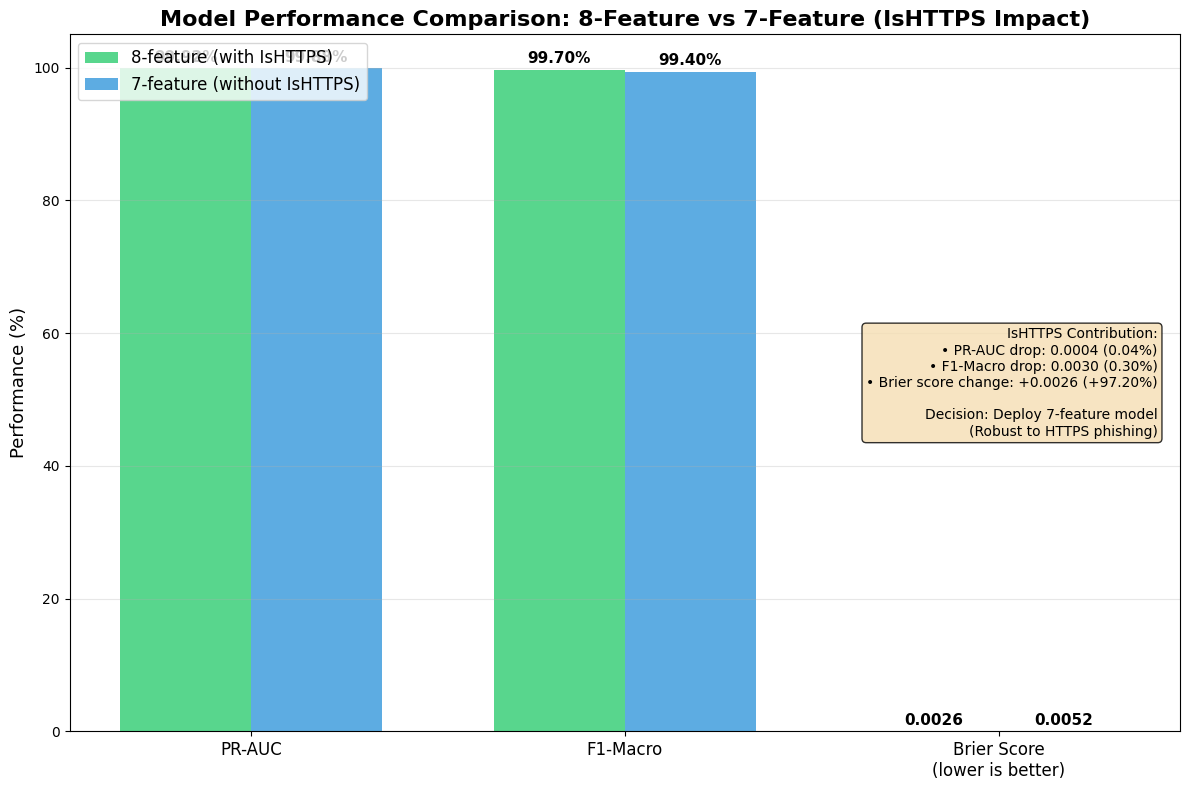

In [21]:
# ============================================================================
#  MODEL PERFORMANCE COMPARISON (8-feat vs 7-feat)
# ============================================================================


def plot_model_comparison():
    """
    Bar chart comparing 8-feature vs 7-feature model performance.
    Uses actual model metrics from memory instead of hardcoded values.
    """
    # Extract actual metrics from the trained models
    metrics = ["PR-AUC", "F1-Macro", "Brier Score\n(lower is better)"]

    # Get actual values from model dictionaries (convert to percentages for display)
    model_8feat_values = [
        model_8feat["metrics"]["pr_auc"] * 100,  # Convert to percentage
        model_8feat["metrics"]["f1_macro"] * 100,  # Convert to percentage
        model_8feat["metrics"]["brier"],  # Keep as decimal for Brier
    ]

    model_7feat_values = [
        model_7feat["metrics"]["pr_auc"] * 100,  # Convert to percentage
        model_7feat["metrics"]["f1_macro"] * 100,  # Convert to percentage
        model_7feat["metrics"]["brier"],  # Keep as decimal for Brier
    ]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))

    # Create bars with actual model names
    bars1 = ax.bar(
        x - width / 2,
        model_8feat_values,
        width,
        label=model_8feat["name"],
        color="#2ecc71",
        alpha=0.8,
    )
    bars2 = ax.bar(
        x + width / 2,
        model_7feat_values,
        width,
        label=model_7feat["name"],
        color="#3498db",
        alpha=0.8,
    )

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            # Format differently for Brier score vs percentages
            if height < 1:  # Brier score
                label = f"{height:.4f}"
            else:  # Percentages
                label = f"{height:.2f}%"
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.5,
                label,
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

    # Labels and formatting
    ax.set_ylabel("Performance (%)", fontsize=13)
    ax.set_title(
        "Model Performance Comparison: 8-Feature vs 7-Feature (IsHTTPS Impact)",
        fontsize=16,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=True)
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim([0, 105])

    # Add annotation with actual calculated differences
    textstr = (
        "IsHTTPS Contribution:\n"
        f"• PR-AUC drop: {pr_auc_drop:.4f} ({pr_auc_drop / model_8feat['metrics']['pr_auc'] * 100:.2f}%)\n"
        f"• F1-Macro drop: {f1_drop:.4f} ({f1_drop / model_8feat['metrics']['f1_macro'] * 100:.2f}%)\n"
        f"• Brier score change: {brier_change:+.4f} ({brier_change / model_8feat['metrics']['brier'] * 100:+.2f}%)\n\n"
        f"Decision: {'Deploy 8-feature model' if pr_auc_drop >= 0.01 or f1_drop >= 0.01 else 'Deploy 7-feature model'}\n"
        f"({'Maximum performance' if pr_auc_drop >= 0.01 or f1_drop >= 0.01 else 'Robust to HTTPS phishing'})"
    )
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
    ax.text(
        0.98,
        0.5,
        textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="center",
        horizontalalignment="right",
        bbox=props,
    )

    plt.tight_layout()
    # Save the figure
    print("✅ Generated: model_comparison_8feat_vs_7feat.png")
    OUT_DIR = Path("outputs")
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(
        OUT_DIR / "model_comparison_8feat_vs_7feat.png", dpi=300, bbox_inches="tight"
    )

    plt.show()


plot_model_comparison()


### **SECTION 7: Model Artifact Persistence**

#### **SECTION 7.1: Model Artifact Persistence**

In [18]:
print("=" * 60)
print("SAVING BOTH MODELS FOR PRODUCTION")
print("=" * 60)

MODEL_DIR = Path("models/dev")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save 8-feature model (research baseline)
MODEL_8_PATH = MODEL_DIR / "model_8feat.pkl"
META_8_PATH = MODEL_DIR / "model_8feat_meta.json"

joblib.dump(best_model, MODEL_8_PATH)

meta_8feat = {
    "feature_order": OPTIMAL_FEATURES,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(best_model).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_8feat["metrics"],
    "thresholds": model_8feat["thresholds"],
    "notes": f"8-feature model with IsHTTPS - research baseline, {model_8feat['metrics']['pr_auc']:.2%} PR-AUC",
}

META_8_PATH.write_text(json.dumps(meta_8feat, indent=2), encoding="utf-8")

model_8_md5 = hashlib.md5(MODEL_8_PATH.read_bytes()).hexdigest()

print(f"\n Saved 8-feature model:")
print(f"  Model: {MODEL_8_PATH}")
print(f"  MD5: {model_8_md5}")
print(f"  Metadata: {META_8_PATH}")

# Save 7-feature model (production candidate)
MODEL_7_PATH = MODEL_DIR / "model_7feat.pkl"
META_7_PATH = MODEL_DIR / "model_7feat_meta.json"

joblib.dump(calib_7feat, MODEL_7_PATH)

meta_7feat = {
    "feature_order": FEATURES_7,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(calib_7feat).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_7feat["metrics"],
    "thresholds": model_7feat["thresholds"],
    "notes": f"7-feature model without IsHTTPS - production candidate, {model_7feat['metrics']['pr_auc']:.2%} PR-AUC, robust to HTTPS phishing",
}

META_7_PATH.write_text(json.dumps(meta_7feat, indent=2), encoding="utf-8")

model_7_md5 = hashlib.md5(MODEL_7_PATH.read_bytes()).hexdigest()

print(f"\n✓ Saved 7-feature model:")
print(f"  Model: {MODEL_7_PATH}")
print(f"  MD5: {model_7_md5}")
print(f"  Metadata: {META_7_PATH}")

# Save thresholds for both
THRESH_8_PATH = Path("configs/dev/thresholds_8feat.json")
THRESH_7_PATH = Path("configs/dev/thresholds_7feat.json")

with open(THRESH_8_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_8feat",
            "features": OPTIMAL_FEATURES,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_8feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

with open(THRESH_7_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_7feat",
            "features": FEATURES_7,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_7feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

print(f"\n Saved thresholds:")
print(f"  8-feature: {THRESH_8_PATH}")
print(f"  7-feature: {THRESH_7_PATH}")

print("\n" + "=" * 60)
print("ARTIFACTS SUMMARY")
print("=" * 60)
print(f"""
Research Model (8-feature with IsHTTPS):
  - PR-AUC: {model_8feat["metrics"]["pr_auc"]:.4f}
  - Purpose: Maximum performance on this dataset
  - Path: {MODEL_8_PATH}

Production Model (7-feature without IsHTTPS):
  - PR-AUC: {model_7feat["metrics"]["pr_auc"]:.4f}  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: {MODEL_7_PATH}
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.
""")


SAVING BOTH MODELS FOR PRODUCTION

 Saved 8-feature model:
  Model: models\dev\model_8feat.pkl
  MD5: 051bdaa874f12d709045c1e25f65316f
  Metadata: models\dev\model_8feat_meta.json

✓ Saved 7-feature model:
  Model: models\dev\model_7feat.pkl
  MD5: a336fd721c1c97ca1f541e48749ee8e2
  Metadata: models\dev\model_7feat_meta.json

 Saved thresholds:
  8-feature: configs\dev\thresholds_8feat.json
  7-feature: configs\dev\thresholds_7feat.json

ARTIFACTS SUMMARY

Research Model (8-feature with IsHTTPS):
  - PR-AUC: 0.9992
  - Purpose: Maximum performance on this dataset
  - Path: models\dev\model_8feat.pkl

Production Model (7-feature without IsHTTPS):
  - PR-AUC: 0.9988  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: models\dev\model_7feat.pkl
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.



#### **SECTION 7.2 MLflow Experiment Logging**

In [19]:
print("\n" + "=" * 60)
print("MLFLOW EXPERIMENT LOGGING")
print("=" * 60)

mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(EXPERIMENT)

run_name = f"{best_name}_optimal8_calibrated"

with mlflow.start_run(run_name=run_name):
    # Log parameters (configuration)
    mlflow.log_params(
        {
            "model_type": best_name,
            "calibration_method": "isotonic",
            "calibration_cv_folds": 5,
            "n_features": len(OPTIMAL_FEATURES),
            "seed": SEED,
            "train_samples": len(X_train),
            "val_samples": len(X_val),
            "data_file": str(DATA_PATH),
        }
    )

    # Log feature list
    for i, feature in enumerate(OPTIMAL_FEATURES, 1):
        mlflow.log_param(f"feature_{i}", feature)

    # Log metrics (performance)
    # ...existing code...
    # Log metrics (performance)
    mlflow.log_metrics(
        {
            "val_pr_auc_phish": best_metrics["pr_auc_phish"],
            "val_f1_macro_at_0.5": best_metrics["f1_macro@0.5_on_p_mal"],
            "val_brier_phish": best_metrics["brier_phish"],
            "t_star": threshold_config["optimal_threshold"],
            "threshold_low": threshold_config["gray_zone_low"],
            "threshold_high": threshold_config["gray_zone_high"],
            "gray_zone_rate": threshold_config["gray_zone_rate"],
        }
    )

    # Save thresholds JSON artifact
    threshold_artifact = {
        "model": best_name,
        "class_mapping": {"phish": 0, "legit": 1},
        "calibration": {"method": "isotonic", "cv": 5},
        "thresholds": threshold_config,
        "data": {"file": str(DATA_PATH)},
        "seed": SEED,
    }

    with open(THRESH_PATH, "w", encoding="utf-8") as f:
        json.dump(threshold_artifact, f, indent=2)

    mlflow.log_artifact(str(THRESH_PATH))

    print(f"\n Logged run: {run_name}")
    print(f" Saved thresholds: {THRESH_PATH}")
    print(f" MLflow UI: {MLFLOW_URI}")



MLFLOW EXPERIMENT LOGGING

 Logged run: xgb_optimal8_calibrated
 Saved thresholds: configs\dev\thresholds.json
 MLflow UI: http://localhost:5000
🏃 View run xgb_optimal8_calibrated at: http://localhost:5000/#/experiments/873624361181467123/runs/23b8f04be32940c9a391563680cebede
🧪 View experiment at: http://localhost:5000/#/experiments/873624361181467123
